<a href="https://colab.research.google.com/github/yadavrishikesh/Deep-Learning-Slides-Code/blob/main/code/ModelValidation/ModelValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model Selection

### Why Do We Split the Data? (Train, Validation, and Test Sets)

When building predictive models, our goal is not just to fit the existing data, but to learn patterns that will generalize to **new, unseen data**.  
To properly evaluate this, we divide the available dataset into **three parts**:

| Dataset | Used For | Purpose |
|--------|----------|---------|
| **Train Set** | Model Fitting | Used to estimate (learn) the model parameters. |
| **Validation Set** | Model Selection | Used to compare different models/complexities and choose the best one. |
| **Test Set** | Final Evaluation | Used only once at the end to report the final performance.

- The **Train set** teaches the model the relationship between inputs and outputs.
- The **Validation set** helps us decide *which model is best* (e.g., simple vs. complex).
- The **Test set** is held back until the very end, so we get an **unbiased estimate** of how well the final model performs on completely new data.

> **Key Idea:**  
> The test data must **never** influence model training or model selection.  
> If we use test data to tune the model, then the performance on test data will be overly optimistic.
> Most often dividing only into two parts serve the whole purpose.



---
## In Pratice


Lets generate a dataset containing a single predictor (independent) variable **x** and a response (depedent) variable **y**.
Now our objective is to:

1. **Split** the dataset into Training (60%), Validation (20%), and Test (20%) sets.
2. Fit **three polynomial regression models**:
   - Model A: Degree 0 (Intercept-only model)
   - Model B: Degree 3
   - Model C: Degree 10
3. Compare the **Training MSE** and **Validation MSE** to select the best model.
4. Re-train the selected model on **Training + Validation data**.
5. Evaluate final performance on the **Test set**.
6. Additionally, perform **10-fold Cross Validation** to verify model stability.
7. Visualize the fitted curves.

In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')


---
## Generate Example Data (You may replace with real dataset)

In [36]:
np.random.seed(1)

n = 300
x = np.random.uniform(-2, 2, n)
y = 1 + 2*x - 0.7*(x**3) + np.random.normal(0, 1, n)

data = pd.DataFrame({'x': x, 'y': y})
data.head()


,x,y
0,-0.331912,0.604441
1,0.881298,2.485282
2,-1.999543,3.258093
3,-0.790670,1.556825
4,-1.412976,0.028290


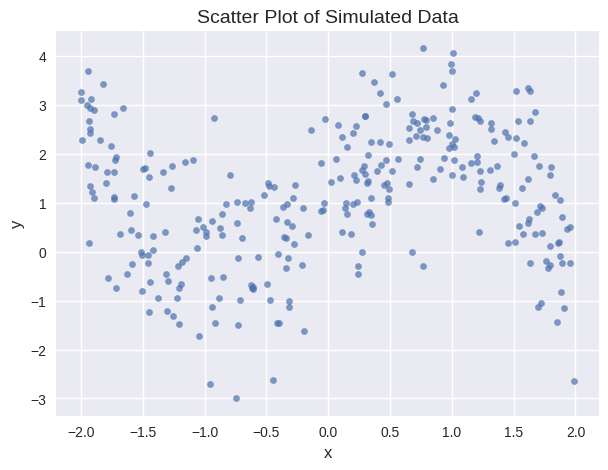

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(data['x'], data['y'], s=20, alpha=0.7)
plt.title("Scatter Plot of Simulated Data", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.show()


---
## Train/Validation/Test Split

In [38]:
train_data, temp = train_test_split(data, test_size=0.4, random_state=2)
valid_data, test_data = train_test_split(temp, test_size=0.5, random_state=2)

train_data.shape, valid_data.shape, test_data.shape


((180, 2), (60, 2), (60, 2))

---
## Function to Fit Polynomial Models

In [39]:
def fit_poly_model(degree, train_df, valid_df):
    poly = PolynomialFeatures(degree=degree)

    X_train = poly.fit_transform(train_df[['x']])
    y_train = train_df[['y']]

    X_valid = poly.transform(valid_df[['x']])
    y_valid = valid_df[['y']]

    model = LinearRegression().fit(X_train, y_train)

    train_mse = mean_squared_error(y_train, model.predict(X_train))
    valid_mse = mean_squared_error(y_valid, model.predict(X_valid))

    return model, poly, train_mse, valid_mse

---
## Fit Candidate Models

In [40]:
results = []

for degree in [0, 3, 10]:
    model, poly, train_mse, valid_mse = fit_poly_model(degree, train_data, valid_data)
    results.append([degree, train_mse, valid_mse])

results_df = pd.DataFrame(results, columns=["Degree", "Train MSE", "Validation MSE"])
results_df

,Degree,Train MSE,Validation MSE
0,0,1.812373,2.109126
1,3,0.950248,1.188403
2,10,0.929574,1.318981


---
## Select Best Model Based on Validation MSE

In [41]:
best_degree = results_df.loc[results_df["Validation MSE"].idxmin(), "Degree"]
best_degree


np.int64(3)

---
## Refit Best Model Using Train+Validation and Test It

In [42]:
train_valid = pd.concat([train_data, valid_data])

best_model, best_poly, _, _ = fit_poly_model(best_degree, train_valid, train_valid)

X_test = best_poly.transform(test_data[['x']])
test_mse = mean_squared_error(test_data[['y']], best_model.predict(X_test))

test_mse


1.0403085797124256

---
## Perform 10-Fold Cross Validation

In [43]:
def cv_mse(degree, df):
    poly = PolynomialFeatures(degree=degree)
    X = poly.fit_transform(df[['x']])
    y = df[['y']]

    model = LinearRegression()
    kf = KFold(n_splits=10, shuffle=True, random_state=3)
    cv_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)

    return -cv_scores.mean()

cv_results = pd.DataFrame({
    "Degree": [0, 3, 10],
    "Cross-Validated MSE": [cv_mse(d, data) for d in [0, 3, 10]]
})

cv_results


,Degree,Cross-Validated MSE
0,0,1.877405
1,3,1.043946
2,10,1.097343


---
## Visualization of Fits

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


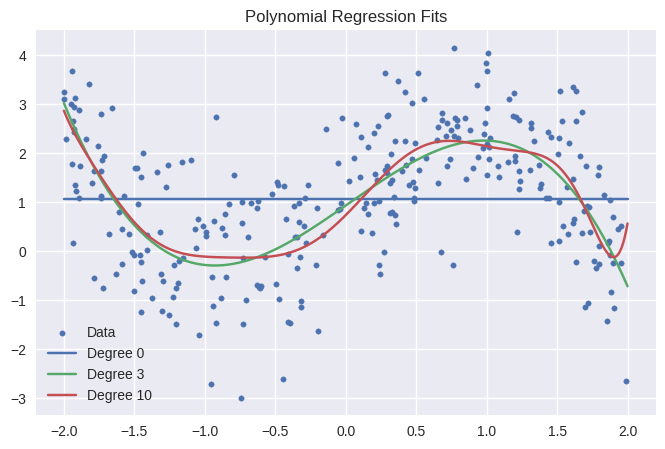

In [44]:
x_plot = np.linspace(-2, 2, 400)

plt.figure(figsize=(8,5))
plt.scatter(data['x'], data['y'], s=15, label="Data")

for degree in [0, 3, 10]:
    model, poly, _, _ = fit_poly_model(degree, train_data, train_data)
    y_pred = model.predict(poly.transform(x_plot.reshape(-1, 1)))
    plt.plot(x_plot, y_pred, label=f"Degree {degree}")

plt.title("Polynomial Regression Fits")
plt.legend()
plt.show()


---
### Summary of Findings

- Degree **0** underfits (high bias).
- Degree **10** overfits (high variance).
- Degree **3** provides the **best balance** and has the lowest **Validation MSE**.

After retraining Model (Degree 3) on **Train + Validation**, the final **Test MSE** confirms good generalization.

Cross-validation results also support selection of **Degree 3**.
